# Batch Prediction with PyTorch

In [1]:
%matplotlib inline

This example follows Torch's [transfer learning tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). We will

1. Finetune a pretrained convolutional neural network on a specific task (ants vs. bees).
2. Use a Dask cluster for batch prediction with that model.

The primary focus is using a Dask cluster for batch prediction.

Note that the base environment on the examples.dask.org Binder does not include PyTorch
or torchvision. To run this example, you'll need to run

```
!conda install -y pytorch-cpu torchvision
```

which will take a bit of time to run.

## Download the data

The PyTorch documentation hosts a small set of data. We'll download and extract it locally.

In [2]:
import urllib.request
import zipfile

In [3]:
filename, _ = urllib.request.urlretrieve("https://download.pytorch.org/tutorial/hymenoptera_data.zip", "data.zip")
zipfile.ZipFile(filename).extractall()

The directory looks like

```
hymenoptera_data/
    train/
        ants/
            0013035.jpg
            ...
            1030023514_aad5c608f9.jpg
        bees/
            1092977343_cb42b38d62.jpg
            ...
            2486729079_62df0920be.jpg
     
    train/
        ants/
            0013025.jpg
            ...
            1030023514_aad5c606d9.jpg
        bees/
            1092977343_cb42b38e62.jpg
            ...
            2486729079_62df0921be.jpg
  
```

Following the [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), we'll finetune the model.

In [4]:
import torchvision
from tutorial_helper import (imshow, train_model, visualize_model,
                             dataloaders, class_names, finetune_model)

## Finetune the model

Our base model is resnet18. It predicts for 1,000 categories, while ours just predicts 2 (ants or bees). To make this model train quickly on examples.dask.org, we'll only use a couple of epochs.

In [5]:
import dask

In [6]:
%%time
model = finetune_model()

Epoch 0/1
----------
train Loss: 0.6196 Acc: 0.6844
val Loss: 0.2042 Acc: 0.9281

Epoch 1/1
----------
train Loss: 0.4517 Acc: 0.7787
val Loss: 0.1458 Acc: 0.9477

Training complete in 0m 4s
Best val Acc: 0.947712
CPU times: user 3.92 s, sys: 2.03 s, total: 5.95 s
Wall time: 6.33 s


Things seem OK on a few random images:

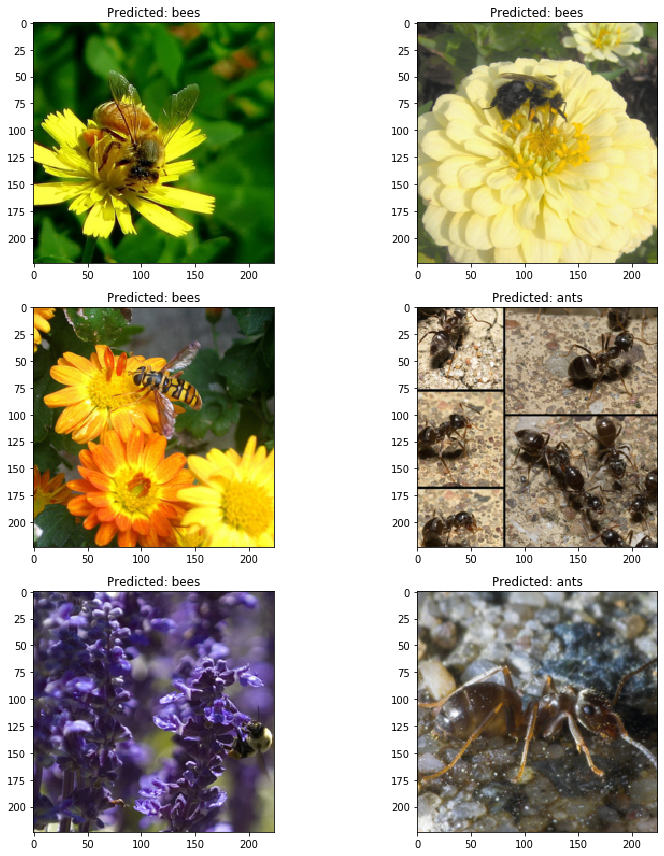

In [7]:
visualize_model(model)

## Batch Prediction with Dask

Now for the main topic: using a pretrained model for batch prediction on a Dask cluster.
There are two main complications, that both deal with minimizing the amount of data
moved around:

1. **Loading the data on the workers.**. We'll use `dask.delayed` to load the data on
   the workers, rather than loading it on the client and sending it to the workers.
2. **PyTorch neural networks are large.** We don't want them in Dask task graphs, and we
   only want to move them around once.

In [8]:
from distributed import Client

client = Client(n_workers=2, threads_per_worker=2)
client

Client Scheduler: tcp://127.0.0.1:46227 Dashboard: http://127.0.0.1:34861/status,Cluster Workers: 2 Cores: 4 Memory: 100.00 GB


### Loading the data on the workers

First, we'll define a couple helpers to load the data and preprocess it for the neural network.
We'll use `dask.delayed` here so that the execuation is lazy and happens on the cluster.
See [the delayed example](../delayed.ipynb) for more on using `dask.delayed`.

In [9]:
import glob
import toolz
import dask
import dask.array as da
import torch
from torchvision import transforms
from PIL import Image


@dask.delayed
def load(path, fs=__builtins__):
    with fs.open(path, 'rb') as f:
        img = Image.open(f).convert("RGB")
        return img


@dask.delayed
def transform(img):
    trn = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return trn(img)

In [10]:
objs = [load(x) for x in glob.glob("hymenoptera_data/val/*/*.jpg")]

To load the data from cloud storage, say Amazon S3, you would use

```python
import s3fs

fs = s3fs.S3FileSystem(...)
objs = [load(x, fs=fs) for x in fs.glob(...)]
```

The PyTorch model expects tensors of a specific shape, so let's
transform them.

In [11]:
tensors = [transform(x) for x in objs]

And the model expects batches of inputs, so let's stack a few together.

In [12]:
batches = [dask.delayed(torch.stack)(batch)
           for batch in toolz.partition_all(10, tensors)]
batches[:5]

[Delayed('stack-da59d324-464a-4dce-adfa-0dc99dc53299'),
 Delayed('stack-939f881b-58ba-4bb5-b4eb-1df6ccfa850f'),
 Delayed('stack-e3809d5d-84f2-4279-a1a6-71131f4d2c53'),
 Delayed('stack-a172c545-7cdd-467f-a2bc-e5c5ae611d50'),
 Delayed('stack-8698c88b-6e05-442d-8346-8af67d0992ae')]

Finally, we'll write a small `predict` helper to predict the output class (0 or 1).

In [13]:
@dask.delayed
def predict(batch, model):
    with torch.no_grad():
        out = model(batch)
        _, predicted = torch.max(out, 1)
        predicted = predicted.numpy()
    return predicted

### Moving the model around

PyTorch neural networks are large, so we don't want to repeat it many times in our task graph (once per batch).

In [14]:
import pickle

dask.utils.format_bytes(len(pickle.dumps(model)))

'44.80 MB'

Instead, we'll also wrap the model itself in `dask.delayed`. This means the model only shows up once in the Dask graph.

Additionally, since we performed fine-tuning in the above (and that runs on a GPU if its available), we should move the model back to the CPU.

In [15]:
dmodel = dask.delayed(model.cpu()) # ensuring model is on the CPU

Now we'll use the (delayed) `predict` method to get our predictions.

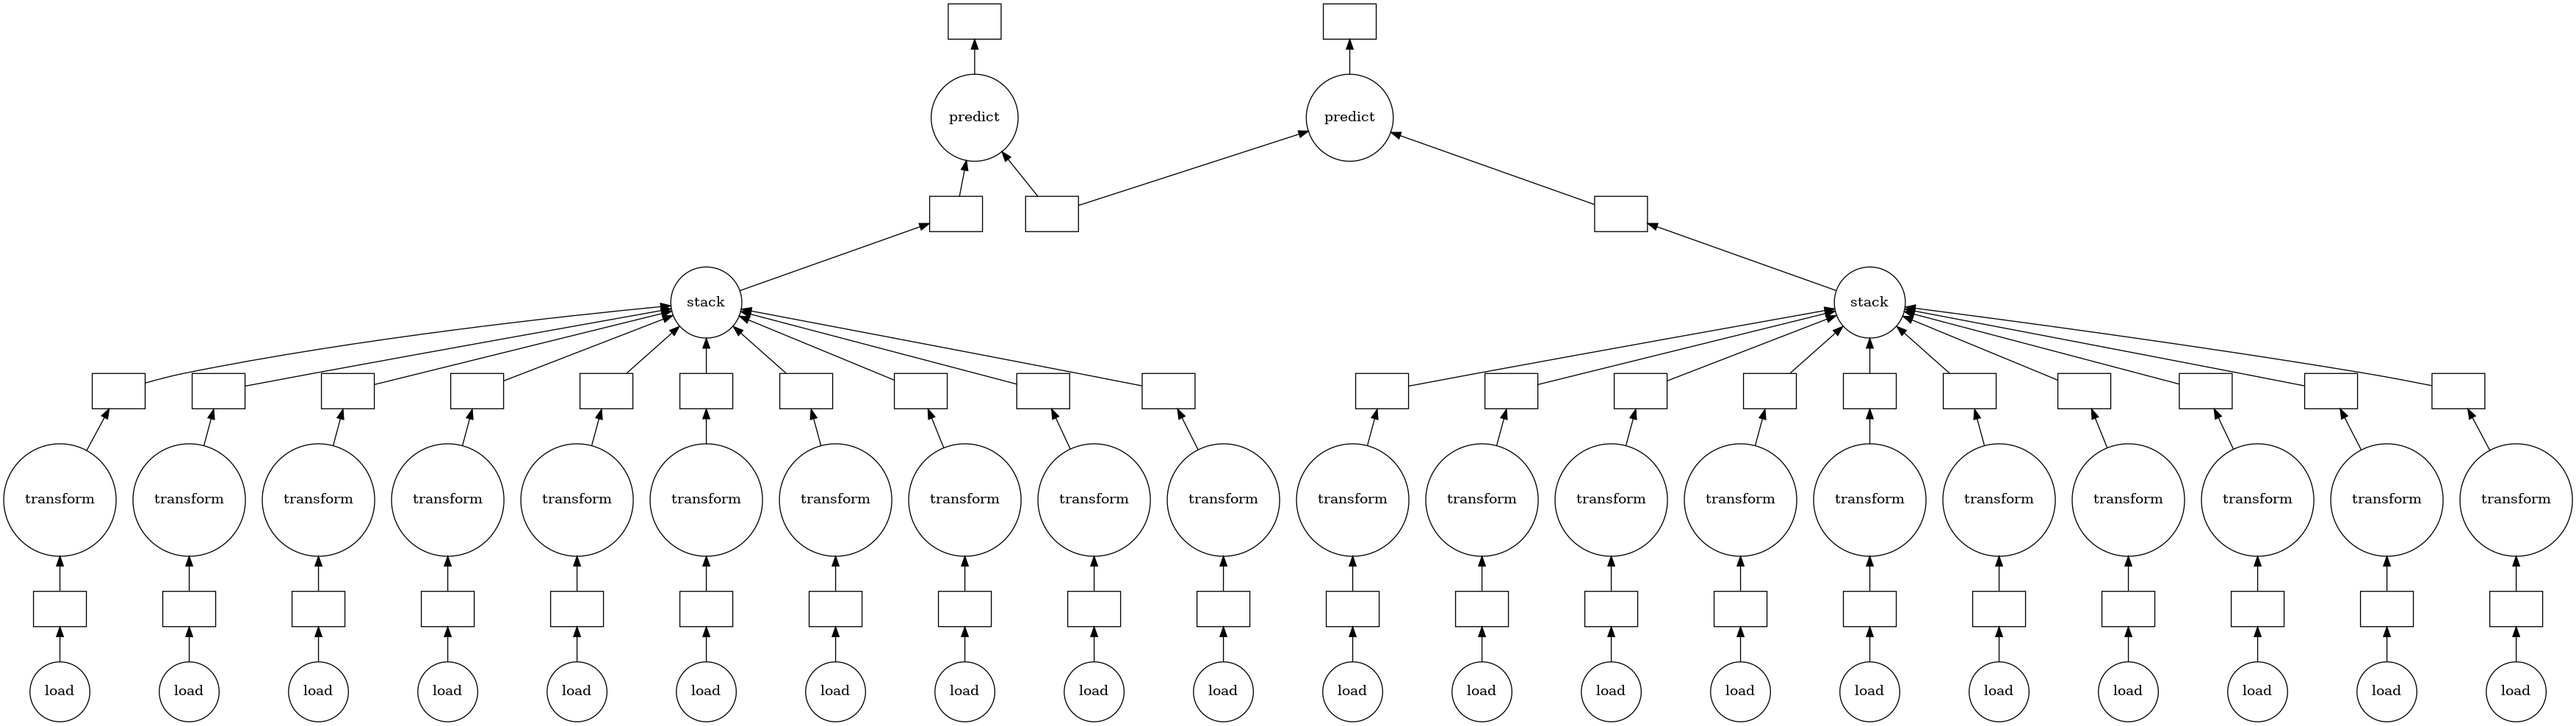

In [16]:
predictions = [predict(batch, dmodel) for batch in batches]
dask.visualize(predictions[:2])

The visualization is a bit messy, but the large PyTorch model is the box that's an ancestor of both `predict` tasks.

Now, we can do the computation, using the Dask cluster to do all the work. Because the dataset we're working with is small, it's safe to just use `dask.compute` to bring the results back to the local Client. For a larger dataset you would want to write to disk or cloud storage or continue processing the predictions on the cluster.

In [17]:
predictions = dask.compute(*predictions)
predictions

(array([1, 1, 1, 0, 1, 0, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0]))

## Summary

This example showed how to do batch prediction on a set of images using PyTorch and Dask.
We were careful to load data remotely on the cluster, and to serialize the large neural network only once.